## Structured Multi-Class Classification with StructureBoost
Often, in multi-class classification problems, the classes in the target variable
possess a *structure* that would be helpful to exploit.

In this notebook, we illustrate how to use StructureBoost to exploit structure
in the target variable of multiclass classification problems.

In this particular example, we will consider a problem where the month of the year is 
the target variable.  The months of the year naturally possess a circular structure as January
is "next to" December in the same way that June is "next to" July.  We will show how exploiting
this structure yields better predictions.  At the same time, we will learn how to configure and
use StructureBoost to exploit the structure in categorical target variables.


## Imports, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import structureboost as stb
import ml_insights as mli

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',999)

In [2]:
df_ca = pd.read_csv('data/CA_weather_both.csv')

## Load the Data and Explore
As you can see below, this is a dataset where each row represents the weather observations from a particular weather station on a particular date.  We know the min and max temperature (TMIN, TMAX), the amount of precipitation (PRCP), as well as the month of the observation and the county where the weather station is located.

California has 58 counties, however, the weather station in Sutter County does not record temperature, so for the purposes of this exercise we are combining Sutter and Yuba counties into a single county "Sutter_Yuba" so that there are 57 counties.  You can see below that we have selected 5000 observations from each of the 57 counties.

In [3]:
df_ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438258 entries, 0 to 2438257
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   county      object 
 1   month       int64  
 2   DATE        object 
 3   STATION     object 
 4   PRCP        float64
 5   rained      int64  
 6   TMAX        float64
 7   TMIN        float64
 8   outcome     int64  
 9   county_num  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 186.0+ MB


In [4]:
df_ca.sample(5)

,county,month,DATE,STATION,PRCP,rained,TMAX,TMIN,outcome,county_num
1302220,Plumas,12,2017-12-21,USC00047195,0.0,0,39.0,17.0,0,31
894245,Merced,6,2010-06-30,USC00046168,0.0,0,100.0,50.0,6,23
2364683,Ventura,6,2006-06-03,USW00093110,0.0,0,76.0,58.0,6,54
1251719,Placer,8,2000-08-27,USC00041912,0.0,0,89.0,55.0,8,30
1125308,Napa,8,2008-08-02,USC00047643,0.0,0,93.0,56.0,8,27


In [5]:
df_ca.county.value_counts()

Los_Angeles        175657
San_Diego          174102
San_Bernardino     136190
Riverside          108895
Kern                93060
Mono                70613
Modoc               67155
Siskiyou            66201
Alameda             61539
Alpine              59257
El_Dorado           57529
Santa_Barbara       55057
Placer              54810
Sonoma              54530
Fresno              53523
Nevada              52865
Shasta              51819
Orange              48769
Tulare              48157
San_Luis_Obispo     47342
Monterey            44078
Napa                42876
Humboldt            40800
Santa_Clara         38591
Merced              37425
Ventura             37135
Inyo                37018
Contra_Costa        36258
Mendocino           35587
Tuolumne            35418
Kings               33282
San_Mateo           33241
Plumas              30979
Butte               29809
Imperial            29753
Sierra              27656
Solano              27312
Santa_Cruz          24621
Trinity     

In [6]:
df_ca.month.value_counts()

3     212138
1     211252
5     208736
7     208343
8     207582
4     203631
10    201396
6     200072
12    199238
9     198255
11    194061
2     193554
Name: month, dtype: int64

## Goal
First, we are going to build a model that tries to predict the month of the year, given the min and max temperature (TMIN, TMAX) and the amount of precipitation (PRCP).  In general, we don't expect to be able to predict the month exactly, but we would like to have an accurate probability distribution on what month it is given the temperatures and precipitation that day.  Thus we will use the `log_loss` to determine the quality of our predictions.

Clearly, there is some meaningful *structure* in the target variable month.  We expect the weather in January to be more similar to December than it is to July.  Thus, it is reasonable to expect that we will get better performance if the model is aware of these similarities during training, rather than just knowing that months are different from one another.


In [7]:
np.unique(df_ca.month)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

As would be expected, the months are numbered 1 through 12.  StructureBoost requires the target to be integers from 0 to num_classes-1.  Thus, we will create a modified "month" variable where December (12) is designated as 0.

In [8]:
tvec = df_ca['month'].copy()
tvec[tvec==12] = 0
df_ca['month_mod'] = tvec

In [9]:
np.unique(df_ca.month_mod)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

Now we'll split the data into training, validation, and test_folds

In [10]:
feat_list = ['TMAX','TMIN','PRCP']
target = 'month_mod'

X = df_ca.loc[:,feat_list]
y = df_ca[target]


In [11]:
# Here we can configure the sizes of our training, validation and test sets (and the rest will be a "remainder")
train_size = 1000
valid_size = 5000
test_size = 100000

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
X_train_rem, X_valid, y_train_rem, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42)
X_train, X_rem, y_train, y_rem = train_test_split(X_train_rem, y_train_rem, train_size=train_size, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, X_rem.shape


((1000, 3), (5000, 3), (100000, 3), (2332258, 3))

## Configuring StructureBoost Target Structure

StructureBoost permits two methods for defining the structure on a target variable:

    1. Using a fixed set of partitions (with corresponding weights)
    2. Using a graph, and randomly choosing partitions from the graph.

The idea is that the partitions provide meaningful "coarsenings" of the target state space.  The loss function, will then be able to take into account that values in the same *block* of the partition are similar.  The beauty of this approach is that we can use many partitions at the same time.

For example, for the months of the year, one might consider that the months of each season tend to have similar weather.  This might lead us to define a partition of the months such as:
{Dec, Jan, Feb}, {Mar, Apr, May}, {Jun, Jul, Aug}, {Sep, Oct, Nov}

In [12]:
# This is a quick way to get a starting feature configuration that can be modified
fc1 = stb.get_basic_config(X_train, stb.default_config_dict())
fc1

{'TMAX': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'TMIN': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'PRCP': {'feature_type': 'numerical', 'max_splits_to_search': 25}}

First we will run StructureBoost with no knowledge of the structure of the months.

In [13]:
# Define the StructureBoost model and fit it
stb0 = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=None, learning_rate=.02)
stb0.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

i=0, eval_set_loss = 2.4863196197521864
i=10, eval_set_loss = 2.396329473329679
i=20, eval_set_loss = 2.336955701546618
i=30, eval_set_loss = 2.2938272762671645
i=40, eval_set_loss = 2.2625749711851126
i=50, eval_set_loss = 2.2416198645540355
i=60, eval_set_loss = 2.226324293892515
i=70, eval_set_loss = 2.214557961034477
i=80, eval_set_loss = 2.207146528026032
i=90, eval_set_loss = 2.201777303378781
i=100, eval_set_loss = 2.197241427537696
i=110, eval_set_loss = 2.194089316466146
i=120, eval_set_loss = 2.1915613509170804
i=130, eval_set_loss = 2.189987787794744
i=140, eval_set_loss = 2.1888735567884097
i=150, eval_set_loss = 2.188989224197152
Stopping early: curr_loss of 2.188989224197152
                                        exceeds compare_loss of 2.1888735567884097


In [14]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_0 = stb0.predict_proba(X_test)
log_loss(y_test, test_preds_0)

2.193247374040555

Next, we will configure StructureBoost using a fixed set of partitions.  We will group the months in "blocks" of size 3 - and there are 3 different partitions, depending on where we start grouping.

StructureBoost assumes you will always use the singleton partition as part of the partition set.  We give a weight using the `singleton_weight` parameter.

The weights for the other partitions in the partition set must be designated by the `partition_weight_vec` parameter.  The weights should sum to 1.  (you will get a warning, but not an error, if this is not the case).

In the example below, the singleton partition has weight 0.4 and the other 3 partitions each have weight 0.2.

In [15]:
# Here we configure the target structure to use a fixed, weighted partition
ts1 = {}
ts1['partition_type'] = 'fixed'
ts1['singleton_weight'] = .4
ts1['partition_list'] = [ [[0,1,2],[3,4,5],[6,7,8],[9,10,11]],
                         [[1,2,3],[4,5,6],[7,8,9],[10,11,0]],
                         [[2,3,4],[5,6,7],[8,9,10],[11,0,1]] ]
ts1['partition_weight_vec'] = [.2,.2,.2]

In [16]:
# Define the StructureBoost model and fit it
stb1 = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts1, learning_rate=.02)

stb1.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

i=0, eval_set_loss = 2.4863196197521864
i=10, eval_set_loss = 2.4047244510636046
i=20, eval_set_loss = 2.346128614124593
i=30, eval_set_loss = 2.301997592514495
i=40, eval_set_loss = 2.269423968030633
i=50, eval_set_loss = 2.2471942956475366
i=60, eval_set_loss = 2.229287716246167
i=70, eval_set_loss = 2.2158349946189695
i=80, eval_set_loss = 2.206075487011261
i=90, eval_set_loss = 2.1982732675754764
i=100, eval_set_loss = 2.192963263661323
i=110, eval_set_loss = 2.1890845025375456
i=120, eval_set_loss = 2.1855804025213357
i=130, eval_set_loss = 2.18340423205977
i=140, eval_set_loss = 2.1818524445856773
i=150, eval_set_loss = 2.1810957607126715
i=160, eval_set_loss = 2.1801758840654015
i=170, eval_set_loss = 2.1800223868023356
i=180, eval_set_loss = 2.180336097887871
Stopping early: curr_loss of 2.180336097887871
                                        exceeds compare_loss of 2.1800223868023356


In [17]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_1 = stb1.predict_proba(X_test)
log_loss(y_test, test_preds_1)

2.182813918607703

In some cases it may be tedious to write out a fixed partition.  There is an alternative, when the desired structure can be represented in terms of a *graph*.  In this case we can simply provide the graph and ask StructureBoost to randomly find partitions of the graph (which respect the structure of the graph).  Then, at each iteration, a different, randomly chosen partition (or partitions) of the graph will be used, in conjunction with the singleton partition.

We show how to configure this below.

In [18]:
# First we must define the appropriate graph
cycle_0_11 = stb.graphs.cycle_int_graph(0,11)
cycle_0_11.vertices, cycle_0_11.edges

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11},
 {frozenset({3, 4}),
  frozenset({2, 3}),
  frozenset({9, 10}),
  frozenset({1, 2}),
  frozenset({4, 5}),
  frozenset({0, 1}),
  frozenset({6, 7}),
  frozenset({8, 9}),
  frozenset({7, 8}),
  frozenset({5, 6}),
  frozenset({0, 11}),
  frozenset({10, 11})})

In [19]:
# Here we configure the target structure to use a variable (random) partition
# We must specify how many partitions we want, and of what sizes
# Note: partition size refers to the *number* of blocks, not the size of the blocks

ts2a = {}
ts2a['partition_type'] = 'variable'
ts2a['target_graph'] = cycle_0_11
ts2a['singleton_weight'] = .5
ts2a['num_partitions'] = 1
ts2a['random_partition_size'] = 4

In [20]:
stb2a = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts2a, learning_rate=.02)

stb2a.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

'rp_method' not configured. Defaulting to 'span_tree'
i=0, eval_set_loss = 2.4863196197521864
i=10, eval_set_loss = 2.401244761203578
i=20, eval_set_loss = 2.341656565548186
i=30, eval_set_loss = 2.299529924977251
i=40, eval_set_loss = 2.2702340870338986
i=50, eval_set_loss = 2.248428144503627
i=60, eval_set_loss = 2.231352335656243
i=70, eval_set_loss = 2.2182466161638645
i=80, eval_set_loss = 2.2090936980161087
i=90, eval_set_loss = 2.2017913503093895
i=100, eval_set_loss = 2.196086691848278
i=110, eval_set_loss = 2.1919235319860313
i=120, eval_set_loss = 2.1885419631702256
i=130, eval_set_loss = 2.187427164547418
i=140, eval_set_loss = 2.1850895051035963
i=150, eval_set_loss = 2.184308935881505
i=160, eval_set_loss = 2.1831796199678886
i=170, eval_set_loss = 2.182624973247668
i=180, eval_set_loss = 2.1828014138362777
Stopping early: curr_loss of 2.1828014138362777
                                        exceeds compare_loss of 2.182624973247668


In [21]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_2a = stb2a.predict_proba(X_test)
log_loss(y_test, test_preds_2a)

2.186071577939376

In [22]:
# This time, let's configure it so that there are multiple partitions, of various sizes
# Each partition is given the same weight (= (1-singleton_weight)/num_partitions))
ts2b = {}
ts2b['partition_type'] = 'variable'
ts2b['target_graph'] = cycle_0_11
ts2b['singleton_weight'] = .5
ts2b['num_partitions'] = 5
ts2b['random_partition_size'] = [3,3,4,5,6]

In [23]:
stb2b = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts2b, learning_rate=.02)

stb2b.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

'rp_method' not configured. Defaulting to 'span_tree'
i=0, eval_set_loss = 2.4863196197521864
i=10, eval_set_loss = 2.401912209182192
i=20, eval_set_loss = 2.344967414865193
i=30, eval_set_loss = 2.3020662928779325
i=40, eval_set_loss = 2.2715219256139765
i=50, eval_set_loss = 2.2491298690083843
i=60, eval_set_loss = 2.232459636374094
i=70, eval_set_loss = 2.219026128548193
i=80, eval_set_loss = 2.20898922240422
i=90, eval_set_loss = 2.2020277635182444
i=100, eval_set_loss = 2.1969143125996435
i=110, eval_set_loss = 2.193469456284114
i=120, eval_set_loss = 2.190387602737842
i=130, eval_set_loss = 2.188009829337936
i=140, eval_set_loss = 2.1860273230675693
i=150, eval_set_loss = 2.1844104060271277
i=160, eval_set_loss = 2.183359551615954
i=170, eval_set_loss = 2.1825701912486415
i=180, eval_set_loss = 2.1828596846273562
Stopping early: curr_loss of 2.1828596846273562
                                        exceeds compare_loss of 2.1825701912486415


In [24]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_2b = stb2b.predict_proba(X_test)
log_loss(y_test, test_preds_2b)

2.186598535214227

## Rigorous testing, Varying the singleton weight
Let's see how this does as we vary the singleton weight from 0.0 to 1.0: Note that a singleton weight of 0 is not recommended, as it means there is no "incentive" to get the month exactly right.  A singleton weight of 1 means that we are not using the structure at all - it is equivalent to setting `target_structure=None` (using a classical approach to multi-classification).

In [25]:
feat_list = ['TMAX','TMIN','PRCP']
target = 'month_mod'

X = df_ca.loc[:,feat_list]
y = df_ca[target]


In [26]:
train_size = 5000
valid_size = 5000
test_size = 100000
num_trials= 5
sw_vec = np.arange(0,11)/10

ll_mat = np.zeros((num_trials, len(sw_vec)))
acc_mat = np.zeros((num_trials, len(sw_vec)))


for tr in range(num_trials):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=42+tr)
    X_train_rem, X_valid, y_train_rem, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42+tr)
    X_train, X_rem, y_train, y_rem = train_test_split(X_train_rem, y_train_rem, train_size=train_size, random_state=42+tr)




    for i,sw in enumerate(sw_vec):
        print('Singleton weight = {}'.format(sw))
        print('trial_number = {}'.format(tr))
        ts = {}
        ts['partition_type'] = 'fixed'
        ts['partition_list'] = [ [[0,1,2],[3,4,5],[6,7,8],[9,10,11]],
                                 [[1,2,3],[4,5,6],[7,8,9],[10,11,0]],
                                 [[2,3,4],[5,6,7],[8,9,10],[11,0,1]] ]
        ts['singleton_weight'] = sw
        rem = (1-sw)/3
        ts['partition_weight_vec'] = [rem, rem, rem]
        stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)
        stb_tmp.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)
        preds_tmp = stb_tmp.predict_proba(X_test)
        ll = log_loss(y_test, preds_tmp)
        hard_preds = np.argmax(preds_tmp,axis=1)
        acc = accuracy_score(y_test,hard_preds)
        ll_mat[tr,i] = ll
        acc_mat[tr,i] = acc

Singleton weight = 0.0
trial_number = 0
i=0, eval_set_loss = 2.4852320238721184
i=10, eval_set_loss = 2.4169632783160107
i=20, eval_set_loss = 2.3626312866163715
i=30, eval_set_loss = 2.319693830429316
i=40, eval_set_loss = 2.2865504673705526
i=50, eval_set_loss = 2.2604589892294866
i=60, eval_set_loss = 2.240669799307921
i=70, eval_set_loss = 2.2248812021523277
i=80, eval_set_loss = 2.2127637098569255
i=90, eval_set_loss = 2.2027594173568525
i=100, eval_set_loss = 2.1949093706741
i=110, eval_set_loss = 2.1886972490440963
i=120, eval_set_loss = 2.1835924073681805
i=130, eval_set_loss = 2.17918367609976
i=140, eval_set_loss = 2.17551127361595
i=150, eval_set_loss = 2.1725463333444845
i=160, eval_set_loss = 2.1696330858975506
i=170, eval_set_loss = 2.167227005634237
i=180, eval_set_loss = 2.165141829335148
i=190, eval_set_loss = 2.1638127671615015
i=200, eval_set_loss = 2.161912677306178
i=210, eval_set_loss = 2.1600838572717875
i=220, eval_set_loss = 2.1588877072619304
i=230, eval_set_l

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_16166/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.3862752751596332
i=20, eval_set_loss = 2.3210659080273306
i=30, eval_set_loss = 2.275979239388689
i=40, eval_set_loss = 2.2445336291043136
i=50, eval_set_loss = 2.2210633512978255
i=60, eval_set_loss = 2.203711384005885
i=70, eval_set_loss = 2.1901418964427095
i=80, eval_set_loss = 2.1801776148315644
i=90, eval_set_loss = 2.1723678319923887
i=100, eval_set_loss = 2.166562333528947
i=110, eval_set_loss = 2.16207015345831
i=120, eval_set_loss = 2.158521793018603
i=130, eval_set_loss = 2.155623124965278
i=140, eval_set_loss = 2.1533063023453214
i=150, eval_set_loss = 2.151005363416668
i=160, eval_set_loss = 2.1497726174492033
i=170, eval_set_loss = 2.148606074892727
i=180, eval_set_loss = 2.1477498234069383
i=190, eval_set_loss = 2.146781199459264
i=200, eval_set_loss = 2.1462697520167167
i=210, eval_set_loss = 2.1455971865494337
i=220, eval_set_loss = 2.1451225916003422
i=230, eval_set_loss = 2.1448364872182015
i=240, eval_set_loss = 2.14461290478501
i=250, eval_s

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_16166/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=20, eval_set_loss = 2.3232981971284694
i=30, eval_set_loss = 2.2782777858362353
i=40, eval_set_loss = 2.2457566539800817
i=50, eval_set_loss = 2.2221207663856783
i=60, eval_set_loss = 2.2042795781246167
i=70, eval_set_loss = 2.1908833996048154
i=80, eval_set_loss = 2.1809097051458295
i=90, eval_set_loss = 2.17333894727841
i=100, eval_set_loss = 2.1670336890753443
i=110, eval_set_loss = 2.1625150102158366
i=120, eval_set_loss = 2.1590443564148547
i=130, eval_set_loss = 2.1565965955406488
i=140, eval_set_loss = 2.154655264159604
i=150, eval_set_loss = 2.1530852542245698
i=160, eval_set_loss = 2.152107697586679
i=170, eval_set_loss = 2.151306196589801
i=180, eval_set_loss = 2.150742999830675
i=190, eval_set_loss = 2.15027408031081
i=200, eval_set_loss = 2.149727886490246
i=210, eval_set_loss = 2.1495058536040297
i=220, eval_set_loss = 2.1492465159334992
i=230, eval_set_loss = 2.1491148481902043
i=240, eval_set_loss = 2.149293475342171
Stopping early: curr_loss of 2.149293475342171
     

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_16166/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.388102636170585
i=20, eval_set_loss = 2.3243897277380157
i=30, eval_set_loss = 2.279638363913079
i=40, eval_set_loss = 2.2483671944828707
i=50, eval_set_loss = 2.224628841969624
i=60, eval_set_loss = 2.207933918198442
i=70, eval_set_loss = 2.194974107614038
i=80, eval_set_loss = 2.185862573129055
i=90, eval_set_loss = 2.1790717573347935
i=100, eval_set_loss = 2.173900995357741
i=110, eval_set_loss = 2.1699864927213124
i=120, eval_set_loss = 2.167241818178608
i=130, eval_set_loss = 2.165242800442544
i=140, eval_set_loss = 2.16320235498588
i=150, eval_set_loss = 2.1620288124926526
i=160, eval_set_loss = 2.161030870075532
i=170, eval_set_loss = 2.1603677651960678
i=180, eval_set_loss = 2.159636658486862
i=190, eval_set_loss = 2.1592423004031787
i=200, eval_set_loss = 2.1589307593271037
i=210, eval_set_loss = 2.1588412922964433
i=220, eval_set_loss = 2.1588031412778568
i=230, eval_set_loss = 2.15852068407571
i=240, eval_set_loss = 2.15869698790245
Stopping early: cu

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_16166/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.3873079604589673
i=20, eval_set_loss = 2.3205364537772257
i=30, eval_set_loss = 2.274083950777217
i=40, eval_set_loss = 2.2413766974856713
i=50, eval_set_loss = 2.2177476643337046
i=60, eval_set_loss = 2.1999127279400876
i=70, eval_set_loss = 2.1863774879801894
i=80, eval_set_loss = 2.1761850906094784
i=90, eval_set_loss = 2.168213330508081
i=100, eval_set_loss = 2.162438605139337
i=110, eval_set_loss = 2.157520511491374
i=120, eval_set_loss = 2.1537492219289676
i=130, eval_set_loss = 2.1506422953506807
i=140, eval_set_loss = 2.1477226361199135
i=150, eval_set_loss = 2.1457967648458065
i=160, eval_set_loss = 2.1442674552222316
i=170, eval_set_loss = 2.142913336466971
i=180, eval_set_loss = 2.14233281773165
i=190, eval_set_loss = 2.1415587338265336
i=200, eval_set_loss = 2.1409451443481946
i=210, eval_set_loss = 2.1405315825681317
i=220, eval_set_loss = 2.139963101658654
i=230, eval_set_loss = 2.139790654551199
i=240, eval_set_loss = 2.1395352166717383
i=250, eva

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_16166/2983974394.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.3886671834675517
i=20, eval_set_loss = 2.323880926796148
i=30, eval_set_loss = 2.2770880896035783
i=40, eval_set_loss = 2.2448505569309245
i=50, eval_set_loss = 2.221099116338714
i=60, eval_set_loss = 2.2035573206243986
i=70, eval_set_loss = 2.1909710006760386
i=80, eval_set_loss = 2.180800477430217
i=90, eval_set_loss = 2.173025579693591
i=100, eval_set_loss = 2.1673336531924448
i=110, eval_set_loss = 2.1629991002648623
i=120, eval_set_loss = 2.159334615797148
i=130, eval_set_loss = 2.1570434962401137
i=140, eval_set_loss = 2.154649704419218
i=150, eval_set_loss = 2.1528211878142525
i=160, eval_set_loss = 2.151600433669546
i=170, eval_set_loss = 2.150514183331752
i=180, eval_set_loss = 2.150059245722301
i=190, eval_set_loss = 2.149300110781176
i=200, eval_set_loss = 2.149087390857483
i=210, eval_set_loss = 2.1486419533928443
i=220, eval_set_loss = 2.148237750460858
i=230, eval_set_loss = 2.1479233997931324
i=240, eval_set_loss = 2.1476147242733568
i=250, eval_s

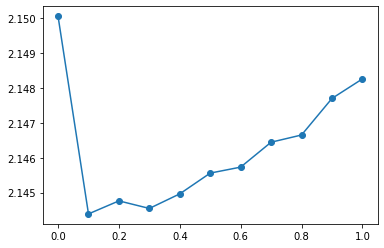

In [27]:
ll_vec = np.mean(ll_mat, axis=0)
plt.plot(sw_vec, ll_vec, marker='o')

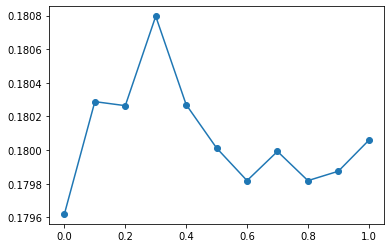

In [28]:
acc_vec = np.mean(acc_mat, axis=0)
plt.plot(sw_vec, acc_vec, marker='o')